In [1]:
#Verifying the location of a periodic signal in the pixel data

In [2]:
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

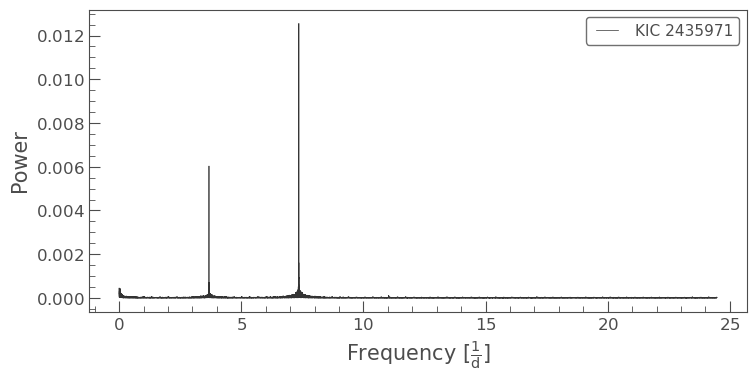

In [3]:
lcs = lk.search_lightcurve('KIC 2435971', author='Kepler', cadence="long").download_all()
lc = lcs.stitch().remove_outliers()
pg = lc.to_periodogram()
pg.plot();

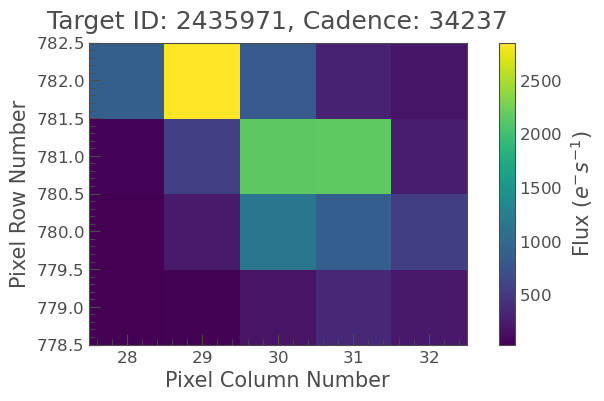

In [4]:
tpf = lk.search_targetpixelfile('KIC 2435971', author='Kepler', quarter=9).download()
tpf.plot();

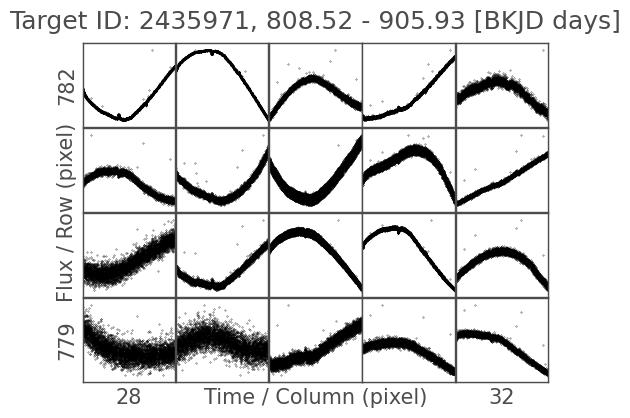

In [5]:
tpf.plot_pixels(); #plotting periodograms in each individual pixels

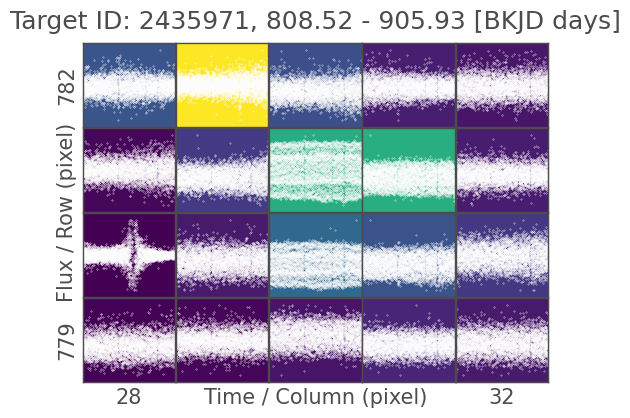

In [6]:
tpf.plot_pixels(corrector_func=lambda x: x.remove_nans().flatten().remove_outliers(), show_flux=True);

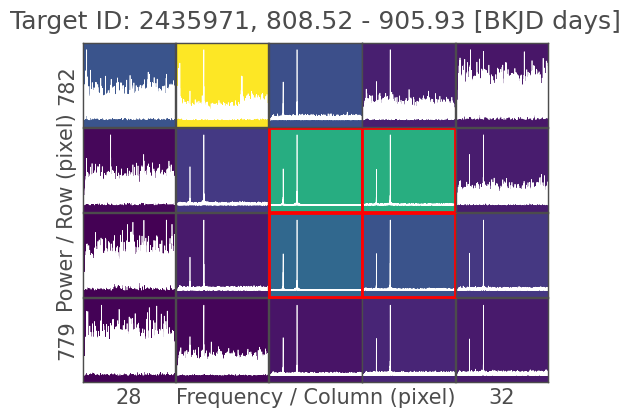

In [7]:
tpf.plot_pixels(corrector_func=lambda x: x.remove_nans().flatten().remove_outliers(), periodogram=True, show_flux=True, aperture_mask='pipeline');
#using pipeline aperture mask 

In [8]:
#Perfoming Difference Imaging
peak = pg.frequency_at_max_power
period = pg.period_at_max_power
print(f'Frequency: {peak:.3f}\nPeriod: {period:.3f}')

Frequency: 7.358 1 / d
Period: 0.136 d


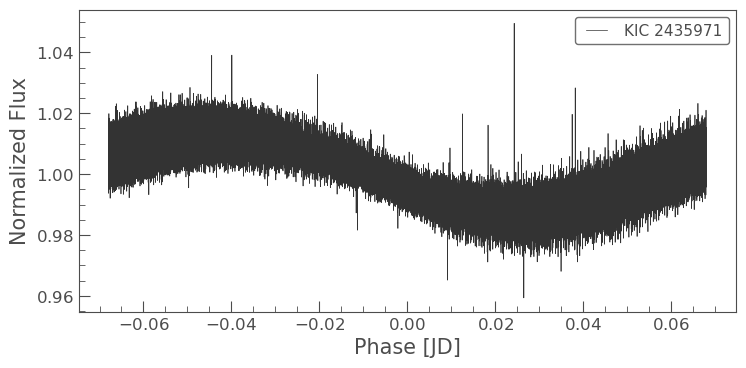

In [9]:
#Determining the maximum and minimum phase times
folded = lc.fold(period, epoch_time=0.5)
folded.plot();

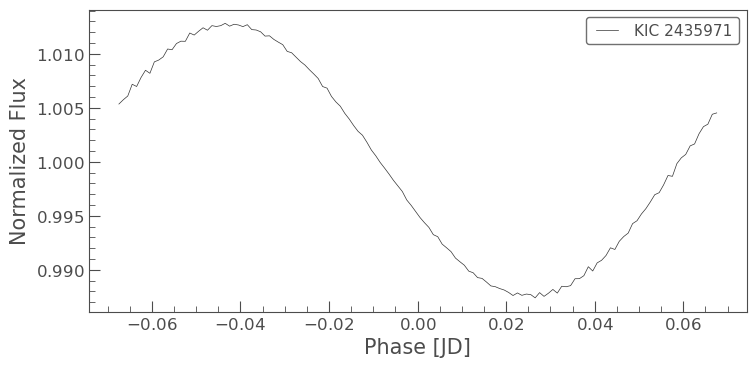

In [10]:
folded2 = folded.bin(time_bin_size=0.001) #to see sinusoidal trend more clearly
folded2.plot();

In [12]:
full_phase_range = folded2.phase[-1].value - folded2.phase[0].value
tolerance = 0.05 * full_phase_range
min_phase = folded2.time[np.argmin(folded2.flux)].value
max_phase = folded2.time[np.argmax(folded2.flux)].value
min_timestamps = folded.time_original[np.where((folded.time > min_phase - tolerance)
                                             & (folded.time < min_phase + tolerance))].value
max_timestamps = folded.time_original[np.where((folded.time > max_phase - tolerance)
                                             & (folded.time < max_phase + tolerance))].value
one_quarter_minima = [f for (f, t) in zip(tpf.flux.value, tpf.time.value) if t in min_timestamps]
one_quarter_maxima = [f for (f, t) in zip(tpf.flux.value, tpf.time.value) if t in max_timestamps]

In [14]:
#Computing the difference image
avg_image = np.nanmean(tpf.flux.value, axis=0)
diff_image = np.abs(np.nanmean(one_quarter_maxima, axis=0) - np.nanmean(one_quarter_minima, axis=0))

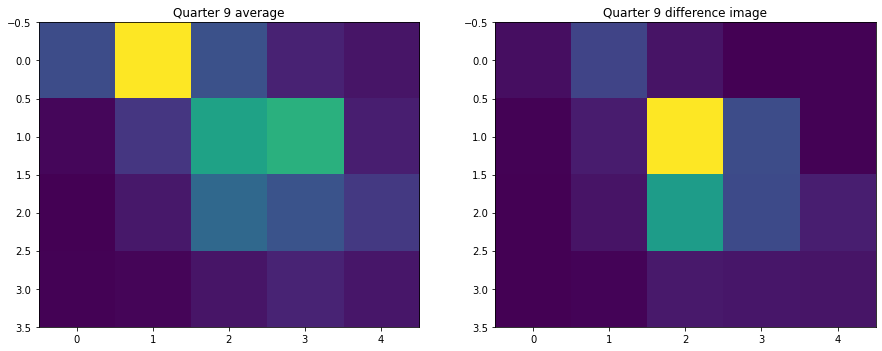

In [15]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(np.flipud(avg_image))
ax[0].set_title('Quarter 9 average')
ax[1].imshow(np.flipud(diff_image))
ax[1].set_title('Quarter 9 difference image')
fig.set_size_inches((15,6))